# Generating CMIP forcing for Wflow.jl

With eWaterCycle we can also generate forcing data from CMIP climate models.

Please do note that the following issue in Wflow.jl has to be resolved first:
https://github.com/Deltares/Wflow.jl/issues/308

In [ ]:
from pathlib import Path
import numpy as np
from ewatercycle_wflowjl.forcing.forcing import WflowJlForcing
from ewatercycle_wflowjl.model import WflowJl
from ewatercycle.base.parameter_set import ParameterSet

## CMIP forcing

The CMIP dataset and ensemble can be selected below. The shape file and Wflow DEM of the catchment are required.

The CMIP data will be downloaded, and the forcing will be generated.

In [ ]:
cmip_dataset = {
    "dataset": "GFDL-ESM2G",
    "project": "CMIP5",
    "grid": "gr",
    "exp": ["historical",],
    "ensemble": "r1i1p1",
}

wflow_forcing = WflowJlForcing.generate(
    dataset=cmip_dataset,
    start_time="1990-01-01T00:00:00Z",
    end_time="1995-12-31T00:00:00Z",
    shape="/home/bart/Documents/wflow_humber/shp/humber_catchment.shp",
    dem_file="/home/bart/Documents/wflow_humber/staticmaps.nc",
)

## Parameter set

Wflow.jl requires parameter data to be able to run. Some example datasets are available on the Wflow.jl documentation.

Here we use a dataset for the Humber (UK) catchment.

In [3]:
parameters_humber = ParameterSet(
    name="humber",
    directory=Path("/home/bart/wflow_humber"),
    target_model="WflowJl",
    config="wflow_sbm.toml",
)

Now we can setup the model:

In [4]:
model = WflowJl(
    parameter_set=parameters_humber,
    forcing=wflow_forcing
)

cfg_file,_ = model.setup()

The model will be initialized using the generated configuration file:

In [5]:
model.initialize(cfg_file)

[ Info: Initialize model variables for model type `sbm`.
[ Info: Cyclic parameters are provided by `/home/bart/wflow_humber/staticmaps.nc`.
[ Info: Forcing parameters are provided by `/home/bart/esmvaltool_output/ewcreplel9wopo_20231027_094138/work/diagnostic/script/wflow_GFDL-ESM2G_humber_catchment_1990_1995.nc`.
[ Info: Set `vertical.precipitation` using NetCDF variable `precip` as forcing parameter.
[ Info: Set `vertical.temperature` using NetCDF variable `temp` as forcing parameter.
[ Info: Set `vertical.potential_evaporation` using NetCDF variable `pet` as forcing parameter.
[ Info: Set `vertical.leaf_area_index` using NetCDF variable `LAI` as cyclic parameter.
┌ Info: General model settings
│   reservoirs = true
│   lakes = false
│   snow = true
│   masswasting = true
└   glacier = false
[ Info: Set `subcatchment` using NetCDF variable `wflow_subcatch`.
[ Info: Set `river_location` using NetCDF variable `wflow_river`.
[ Info: Set `lateral.river.width` using NetCDF variable `wflow

To make the model advance a time step, use `.update()`:

In [6]:
model.update()

We can extract timeseries for subcatchments using the Basic Model Interface:

In [7]:
#      Location A, Location B.
lats = [53.274166, 53.765833,]
lons = [-0.761666, -0.986666,]

ntimesteps = int(model._bmi.get_end_time() / model._bmi.get_time_step()) - 1
q_locs = np.zeros((ntimesteps, 2,))
dtimes = []
for tstep in range(ntimesteps):
    model.update()
    q_locs[tstep] = model.get_value_at_coords("lateral.river.q_av", lats, lons)
    dtimes.append(model.time_as_datetime)

After extracting the discharge data, we can plot it:

Text(0, 0.5, 'discharge [m3/s]')

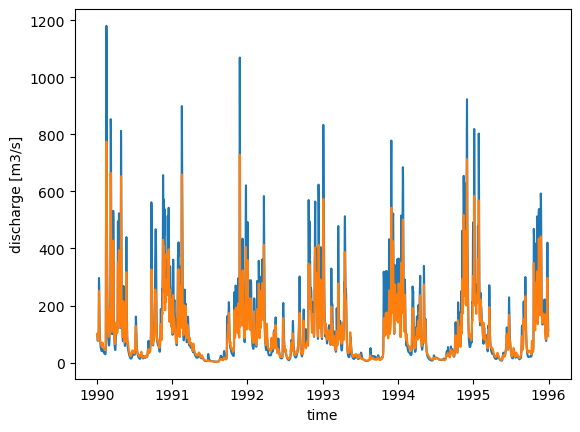

In [8]:
import matplotlib.pyplot as plt
plt.plot(dtimes, q_locs[:, 0])
plt.plot(dtimes, q_locs[:, 1])
plt.xlabel("time")
plt.ylabel("discharge [m3/s]")